# Plot and inspect MCMC output

In [1]:
%config Completer.use_jedi = False  # To allow autoplete (fix a bug)
from IPython.display import display
import emcee
import moana
import numpy as np
import pandas as pd

## Parameters

In [2]:
# Constants
OSIRIS_PIX_SCALE = 9.952  # mas per pixel

# Select your run
run_id = 'my_rescaled_mcmc'

# Select how many MCMC steps you want to throw away (burn-in)
burnin = 10

In [3]:
reader = emcee.backends.HDFBackend(f"{run_id}.h5")
print(f'Autocorrelations')
print(f'    Shape: {reader.get_chain(discard=0, flat=False).shape}')
print(f'   {reader.get_autocorr_time(quiet=True)}')
samples = reader.get_chain(discard=burnin, flat=True)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True)
nstar_out = reader.get_blobs(discard=burnin, flat=True)

# Compute missing quantities and miscellaneous things
colnames = np.array(['x1', 'y1', 'x2', 'y2', 'flux_ratio'])
mcmc_out = pd.DataFrame(samples, columns=colnames)
mcmc_out['FTOTAL'] = nstar_out['z0']

# Don't forget to take into account when flux ratio > 1.0
# TODO: remove that!
mask = mcmc_out['flux_ratio'] > 1
mcmc_out.loc[mask, 'flux_ratio'] = 1 / mcmc_out.loc[mask, 'flux_ratio']
x1 = mcmc_out.loc[mask, 'x2']
y1 = mcmc_out.loc[mask, 'y2']
x2 = mcmc_out.loc[mask, 'x1']
y2 = mcmc_out.loc[mask, 'y1']
mcmc_out.loc[mask, 'x1'] = x1
mcmc_out.loc[mask, 'y1'] = y1
mcmc_out.loc[mask, 'x2'] = x2
mcmc_out.loc[mask, 'y2'] = y2
mcmc_out['chi2'] = - 2.0 * log_prob_samples
mcmc_out['dchi2'] = mcmc_out['chi2'] - np.min(mcmc_out['chi2'])
print("\nBest-fit:")
display(mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])])

# Load info from the log file
with open(f"{run_id}.txt", 'r') as file: logfile = file.read()
dof = [int(a.split(':')[-1].strip()) for a in logfile.split('\n') 
       if a!='' if 'egrees of freedom:' in a][-1]
print(f"Reduced chi-square: {np.min(mcmc_out['chi2']) / dof:.6f}")

Autocorrelations
    Shape: (10000, 10, 5)
   [50.4919619  44.55566218 64.08421754 56.23791871 64.68556358]

Best-fit:


,x1,y1,x2,y2,flux_ratio,FTOTAL,chi2,dchi2
40473,1112.529542,1183.223215,1112.354496,1189.988676,0.857112,0.860413,776.826755,0.0


Reduced chi-square: 0.999777


Each sub-plot must be 4.863in x 4.863in to have a figure of 6.614in. Okay! I'm using it!


<Figure size 432x288 with 0 Axes>

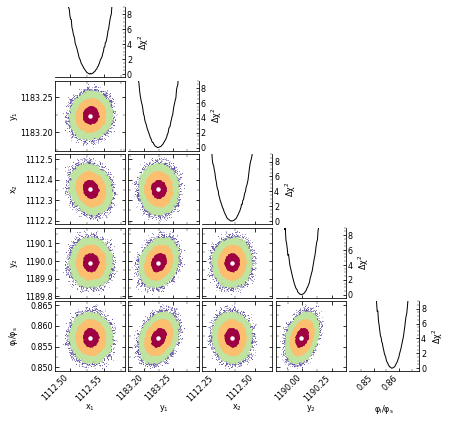

In [4]:
# Plot scatter plot
labels = ['x1', 'y1', 'x2', 'y2', 'flux_ratio']

label_display = dict({'x1': r'x_1', 'x2': r'x_2', 'y1': r'y_1', 'y2': r'y_2',   
    'flux_ratio': r'\varphi_l/\varphi_s'})

mask = mcmc_out['dchi2'] < 100

posterior = moana.SampledPosterior(mcmc_out[mask], labels=labels)
fig, ax = posterior.corner_plot(credible_intervals=False, diagonal='chi2', 
    rotation=45, show_samples=True, labels=label_display);

bf = mcmc_out[mcmc_out['chi2']==np.min(mcmc_out['chi2'])][labels].values[0]
[ax[j][i].scatter(bf[i], bf[j], s=20, lw=0, marker='o', c='w') 
 for i in range(len(labels)) for j in range(len(labels)) if i<j]

# Save the figure
fig.savefig('correlation.png', bbox_inches='tight', dpi=72, pad_inches=0.1)